In [3]:
# base
import numpy as np
import matplotlib.pyplot as plt
import random

# database
import pickle

# models
from models.baselines_models import random_search, tfidf_search, bm25_search

from models.bert_model import bert

# metrics
from metrics.metrics_functions import mean_precision_at_k, mean_average_precision_at_k, mean_recall_at_k, mean_reciprocal_rank, mean_ndcg_at_k

C:\Users\otavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Baselines

Como baselines, vamos utilizar os seguintes modelos: 

### Aleatório:

- Aqui vamos pegar aleatóriamente K documentos para cada query. A ideia é que esse é o pior caso possível para qualquer modelo.

---

### TF-IDF:

#### 1. Frequência de Termos (TF)

Para um documento $d$ e um termo $t$, a frequência do termo é definida como:

$$
\text{TF}(t, d) = \frac{f(t,d)}{\sum_{t'} f(t', d)}
$$

- $f(t,d)$: número de vezes que o termo $t$ aparece no documento $d$.
- $\sum_{t'} f(t', d)$: soma das frequências de todos os termos em $d$.

Essa normalização evita que documentos maiores influenciem excessivamente os valores absolutos dos termos.


#### 2. Frequência Inversa de Documentos (IDF)

O IDF avalia a importância de um termo no corpus, diminuindo o peso de termos que ocorrem em muitos documentos. Para um termo $t$ em um conjunto de documentos $D$ com $N = |D|$ documentos, a fórmula é:

$$
\text{IDF}(t, D) = \log \left(\frac{N}{n_t}\right)
$$

- $N$: número total de documentos.
- $n_t$: número de documentos que contêm o termo $t$.

Uma variação suavizada que evita problemas com divisões por zero é:

$$
\text{IDF}(t, D) = \log \left(1 + \frac{N}{1 + n_t}\right)
$$


#### 3. Cálculo do TF-IDF

O valor TF-IDF para um termo $t$ em um documento $d$ é obtido multiplicando o TF pelo IDF:

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Cada documento $d$ é representado como um vetor $ \mathbf{v}_d $, onde cada componente $ v_{d,t} $ é o peso TF-IDF do termo $t$ no documento.

#### 4. Similaridade Cosseno

Para comparar a similaridade entre dois vetores (por exemplo, o vetor de uma query e o vetor de um documento), utiliza-se a **similaridade cosseno**. Dado um vetor da query $ \mathbf{v}_q $ e um vetor do documento $ \mathbf{v}_d $, a similaridade é calculada como:

$$
\text{sim}(\mathbf{v}_q, \mathbf{v}_d) = \frac{\mathbf{v}_q \cdot \mathbf{v}_d}{\|\mathbf{v}_q\| \, \|\mathbf{v}_d\|}
$$

Onde:
- $\mathbf{v}_q \cdot \mathbf{v}_d = \sum_{t \in V} v_{q,t} \cdot v_{d,t}$ é o produto escalar dos vetores.
- $\|\mathbf{v}_q\| = \sqrt{\sum_{t \in V} v_{q,t}^2}$ e $\|\mathbf{v}_d\| = \sqrt{\sum_{t \in V} v_{d,t}^2}$ são as normas dos vetores.
- $V$ é o vocabulário (conjunto de todos os termos).

Valores próximos de 1 indicam que os vetores (e, portanto, os documentos) são muito similares.


---

### BM25:

BM25 (Best Matching 25) é uma função de ranking utilizada em sistemas de recuperação de informação para classificar documentos com base na relevância em relação a uma query. Ele é fundamentado em modelos probabilísticos e considera fatores como a frequência dos termos, o tamanho do documento e a distribuição dos termos no corpus.

#### Fórmula do BM25

Para um documento $D$ e uma query $Q$, o score BM25 é calculado como:

$$
\text{score}(D, Q) = \sum_{t \in Q} \text{IDF}(t) \cdot \frac{f(t, D) \cdot (k_1 + 1)}{f(t, D) + k_1 \cdot \left(1 - b + b \cdot \frac{|D|}{\text{avgdl}}\right)}
$$

Onde:
- $f(t, D)$ é a frequência do termo $t$ no documento $D$.
- $|D|$ é o tamanho do documento $D$ (número de palavras).
- $\text{avgdl}$ é o tamanho médio dos documentos no corpus.
- $k_1$ é um parâmetro que controla a saturação da frequência do termo (valores comuns variam entre 1.2 e 2.0).
- $b$ é um parâmetro que ajusta o impacto do tamanho do documento (geralmente, $b = 0.75$).
- $\text{IDF}(t)$ é a frequência inversa do documento para o termo $t$, que pode ser calculada como:

$$
\text{IDF}(t) = \log \left(\frac{N - n_t + 0.5}{n_t + 0.5} + 1\right)
$$

Onde:
- $N$ é o número total de documentos no corpus.
- $n_t$ é o número de documentos que contêm o termo $t$.



## Base de dados

In [4]:
PATH = 'subset_msmarco_train_0.01_9.pkl'
PATH_DATA = '../data/' + PATH
PATH_DATA_CLEAN = '../data/data_clean/' + PATH

In [5]:
with open(PATH_DATA, 'rb') as f:
    data = pickle.load(f)

Queries:

In [6]:
# Convertendo o dicionário de queries para formato id:text
queries_dict = {qid: query.text for qid, query in data['queries'].items()}
print(queries_dict)
print(f'Quantidade de queries: {len(queries_dict)}')

{'267878': 'how long till i can bath after a tattoo', '951310': 'when is next fed meeting', '655502': 'what does yyc airport code stand for?', '1169672': 'the defense definition', '841069': 'what is the probable cause of sterility in untreated gonorrhea', '973761': 'where does reishi grow?', '502230': 'stahp meaning', '995986': 'where is the hills located in lynchburg va', '891081': 'what removes permanent hair dye from skin?', '843689': 'what is the redemption period', '75984': 'can you be charged for possession of weapon', '679524': 'what is a counterpoise', '685216': 'what is a good hdl reading', '257521': 'how long does it take to heal a broken thumb', '653057': 'what does the term birds beak in framing', '845379': 'what is the salary of a massage therapist', '1004472': 'where would a labral tear in hip cause pain', '781691': 'what is part c of medicare for', '1160001': 'what does this heyyyy mean', '673045': 'what is UAE ae abbreviated for', '663839': 'what girl name means pink', 

Docs:

In [7]:
# Convertendo o dicionário de docs para formato id:text
docs_dict = {did: doc.text for did, doc in data['docs'].items()}
print(docs_dict)
print(f'Quantidade de docs: {len(docs_dict)}')

{'msmarco_passage_31_15605486': 'Summary. Factor VII deficiency is a rare genetic bleeding disorder characterized by a deficiency or reduced activity of clotting factor VII. Clotting factors are specialized proteins that are essential for the blood to clot normally. Individuals with factor VII deficiency can experience prolonged, uncontrolled bleeding episodes.', 'msmarco_passage_31_211784428': 'The average national monthly non-subsidized health insurance premium for one person on a benchmark plan (i.e., “Silver” plan) is $462 per month, or $199 with a subsidy. Monthly premiums for ACA Marketplace plans vary by state and can be reduced by subsidies.', 'msmarco_passage_31_240307988': 'Qualifying investment fees are tax deductible, but only as a miscellaneous itemized deduction. Miscellaneous itemized deductions are subject to the 2% of AGI (adjusted gross income) floor, and an AMT or alternative minimum tax adjustment (if applicable).', 'msmarco_passage_31_315887924': 'Budville is 6,070

Qrels:

In [8]:
# Criando um dicionário para armazenar as relações query-documentos
qrels_dict = {}

# Iterando sobre os qrels para construir o dicionário
for qrel in data['qrels']:
    query_id = qrel.query_id
    doc_id = qrel.doc_id
    
    # Se a query já existe no dicionário, adiciona o doc à lista
    if query_id in qrels_dict:
        qrels_dict[query_id].append(doc_id)
    # Se não existe, cria uma nova lista com o doc
    else:
        qrels_dict[query_id] = [doc_id]

print(qrels_dict)
print(f'Quantidade de qrels: {len(qrels_dict)}')

{'135841': ['msmarco_passage_16_93510573'], '1072113': ['msmarco_passage_03_76282697'], '66325': ['msmarco_passage_03_779837601'], '622007': ['msmarco_passage_18_4266000'], '406188': ['msmarco_passage_58_532087922'], '1165821': ['msmarco_passage_30_412868914', 'msmarco_passage_38_275215226'], '554489': ['msmarco_passage_66_221933064'], '434121': ['msmarco_passage_51_367320295'], '667985': ['msmarco_passage_09_277446198'], '430794': ['msmarco_passage_09_761274875', 'msmarco_passage_01_526390274'], '713518': ['msmarco_passage_05_499855546'], '711391': ['msmarco_passage_58_307305086'], '702173': ['msmarco_passage_03_167649186'], '290696': ['msmarco_passage_09_678489406'], '38435': ['msmarco_passage_04_319297362'], '609486': ['msmarco_passage_08_254945485'], '417850': ['msmarco_passage_55_497259205'], '59789': ['msmarco_passage_46_112655799'], '606868': ['msmarco_passage_48_416651384'], '49498': ['msmarco_passage_09_720358270'], '521321': ['msmarco_passage_07_596465899'], '815673': ['msmar

#### Limpeza de dados

Vamos testar também os dados após a limpeza. Nossa limpeza consiste em:
- Remover pontuações
- Remover stopwords
- Aplicar stemming: transformar palavras em suas raízes. 

In [9]:
# Se você nunca baixou esses recursos NLTK, descomente as linhas abaixo:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('rslp')
# nltk.download('punkt_tab')

# queries_dict_clean, docs_dict_clean = clean_texts(queries_dict, docs_dict)

# Caso tenha os dados baixados
with open(PATH_DATA_CLEAN, 'rb') as f:
    data_clean = pickle.load(f)

docs_dict_clean = data_clean['docs_dict']
queries_dict_clean = data_clean['queries_dict']


print("Queries limpas:")
print(len(queries_dict_clean))
print("\nDocs limpos:")
print(len(docs_dict_clean))

Queries limpas:
2771

Docs limpos:
27778


### Split de dados

Para esses baselines, não precisamos do conjunto de treinamento, mas vamos usar o conjunto de teste para avaliar o desempenho dos modelos.

In [10]:
random.seed(42)

# Split the queries (assuming queries is a dictionary of {query_id: query_object})
query_ids = list(queries_dict.keys())  # List of query IDs

# Shuffle query IDs to ensure a random split
random.shuffle(query_ids)

# Split into 80% for training, 20% for validation
split_ratio = 0.8
test_query_ids = query_ids[int(len(query_ids) * split_ratio):]

test_queries_dict = {qid: queries_dict[qid] for qid in test_query_ids}
test_queries_dict_clean = {qid: queries_dict_clean[qid] for qid in test_query_ids}

print(len(queries_dict))
print(len(queries_dict_clean))
print(len(test_queries_dict))
print(len(test_queries_dict_clean))

2771
2771
555
555


## Aleatório:

In [11]:
# quantidade de documentos a serem retornados
K = 25

In [12]:
top10_results_random, execution_time_random = random_search(docs_dict, test_queries_dict, K=10)
print(execution_time_random)

100%|██████████| 555/555 [00:00<?, ?it/s]

0.012775421142578125


## TF-IDF

Queries e Docs sem limpeza:

In [13]:
top10_results_tfidf, execution_time_tfidf = tfidf_search(docs_dict, test_queries_dict, K=10)
print(execution_time_tfidf)

100%|██████████| 555/555 [00:00<00:00, 2419.72it/s]

1.2347676753997803


Queries e Docs com limpeza:

In [14]:
top10_results_tfidf_clean, execution_time_tfidf_clean = tfidf_search(docs_dict_clean, test_queries_dict_clean, K=10)
print(execution_time_tfidf_clean)

100%|██████████| 555/555 [00:00<00:00, 2305.08it/s]

0.7047600746154785


## BM25

Queries e Docs sem limpeza:

In [15]:
topN_results_bm25, execution_time_bm25 = bm25_search(docs_dict, test_queries_dict, K=10)
print(execution_time_bm25)

100%|██████████| 555/555 [00:24<00:00, 22.81it/s]

24.934518098831177


Queries e Docs com limpeza:

In [16]:
topN_results_bm25_clean, execution_time_bm25_clean = bm25_search(docs_dict_clean, test_queries_dict_clean, K=10)
print(execution_time_bm25_clean)

100%|██████████| 555/555 [00:10<00:00, 53.04it/s]

10.873013257980347


In [17]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

top10_results_bert, execution_time_bert = bert(docs_dict, test_queries_dict, tokenizer, model, batch_size=32)
print(execution_time_bert)

Retrieving top-K docs: 100%|██████████| 555/555 [00:02<00:00, 264.52query/s]

2130.484976053238


## Métricas:

#### 1. Precision@K

A **Precision@K** para uma única query é definida como:

$$
\text{Precision@K} = \frac{\text{número de documentos relevantes nos top } K}{K}
$$

- **Intuição:**

    - **O que mede:** A proporção dos documentos entre os \(K\) primeiros resultados que são de fato relevantes.
    - **Importância:** Alta precisão indica que os primeiros resultados apresentados ao usuário são, em sua maioria, relevantes.

- **Domínio de Valores:**

    - **Valores:** Entre 0 e 1.
    - **0:** Nenhum dos \(K\) documentos é relevante.
    - **1:** Todos os \(K\) documentos são relevantes.


#### 2. Mean Precision@K

A **Mean Precision@K (mP@K)** é a média das precisões calculadas para cada query individualmente. Se temos um conjunto de queries, a média é dada por:

$$
\text{Mean Precision@K} = \frac{1}{Q} \sum_{q=1}^{Q} \text{Precision@K}_q
$$

Onde \(Q\) é o número total de queries.

- **Intuição:**

    - **O que mede:** Uma visão geral da precisão do sistema em todas as queries.
    - **Importância:** Permite avaliar o desempenho médio do sistema de recuperação de informação.

- **Domínio de Valores:**

    - **Valores:** Entre 0 e 1, com a mesma interpretação de 0 (pior desempenho) e 1 (melhor desempenho).

---

#### 3. Recall@K

O **Recall@K** para uma query é definido como:

$$
\text{Recall@K} = \frac{\text{número de documentos relevantes nos top } K}{\text{total de documentos relevantes}}
$$

- **Intuição:**
    - **O que mede:** A fração dos documentos relevantes que foram recuperados entre os \(K\) primeiros resultados.
    - **Importância:** Avalia a capacidade do sistema de encontrar todos os documentos relevantes, independentemente de sua posição no ranking.

- **Domínio de Valores:**
    - **Valores:** Entre 0 e 1.
    - **0:** Nenhum dos documentos relevantes foi recuperado nos top \(K\).
    - **1:** Todos os documentos relevantes estão entre os \(K\) primeiros resultados.

#### 4. Mean Recall@K

- **Matemática:**

A **Mean Recall@K (mR@K)** é a média dos recalls individuais para cada query:

$$
\text{Mean Recall@K} = \frac{1}{Q} \sum_{q=1}^{Q} \text{Recall@K}_q
$$

- **Intuição:**
    - **O que mede:** O desempenho médio do sistema na recuperação de todos os documentos relevantes.
    - **Importância:** Útil quando se deseja avaliar a abrangência do sistema de busca.

- **Domínio de Valores:**
    - **Valores:** Entre 0 e 1, com interpretações similares às métricas individuais.

---

#### 5. Average Precision (AP)

- **Matemática:**

A **Average Precision (AP)** para uma query leva em conta não apenas quantos documentos relevantes foram recuperados, mas também a posição em que eles aparecem no ranking. Ela é definida como:

$$
\text{AP} = \frac{1}{|\text{relevant\_docs}|} \sum_{i=1}^{K} \mathbb{1}\{\text{doc}_i \text{ é relevante}\} \cdot \text{Precision@}i
$$

Onde:
- $\mathbb{1}\{\cdot\}$ é a função indicadora, que vale 1 se o documento na posição $i$ for relevante, e 0 caso contrário.
- $\text{Precision@}i$ é a precisão calculada considerando os $i$ primeiros documentos.

- **Intuição:**
    - **O que mede:** A média das precisões calculadas nos pontos onde um documento relevante é recuperado.
    - **Importância:** Recompensa rankings que trazem documentos relevantes para as primeiras posições, sendo particularmente útil quando a ordem dos resultados é importante.

- **Domínio de Valores:**
    - **Valores:** Entre 0 e 1.
    - **0:** Nenhum documento relevante é recuperado.
    - **1:** Todos os documentos relevantes são recuperados nas primeiras posições (ideal).

---

#### 6. Mean Average Precision (MAP@K)

- **Matemática:**

A **Mean Average Precision (MAP@K)** é a média da AP de todas as queries:

$$
\text{MAP@K} = \frac{1}{Q} \sum_{q=1}^{Q} \text{AP}_q
$$

- **Intuição:**
    - **O que mede:** O desempenho global do sistema, levando em conta tanto a quantidade quanto a posição dos documentos relevantes para cada query.
    - **Importância:** É uma das métricas mais robustas para avaliar sistemas de recuperação de informação, pois agrega informações de todas as queries.

- **Domínio de Valores:**
    - **Valores:** Entre 0 e 1.
- **Valores:** Entre 0 e 1.
  - **0:** Desempenho ruim, onde os documentos relevantes raramente aparecem.
  - **1:** Desempenho perfeito, onde todos os documentos relevantes aparecem nas primeiras posições para todas as queries.
para atender às necessidades dos usuários.

## 7. Mean Reciprocal Rank (MRR)

- **Definição**  
  A MRR é a média do Reciprocal Rank (RR) para um conjunto de queries. O RR de uma query é calculado como $\frac{1}{\text{posição do primeiro documento relevante}}$. Se não existir documento relevante, $RR = 0$.

- **Intuição**  
  Mede quão cedo o primeiro documento relevante aparece no ranking. Valores altos indicam que os documentos relevantes geralmente aparecem nas primeiras posições.

- **Fórmula**  
  $$
    \text{MRR} = \frac{1}{Q} \sum_{q=1}^{Q} \frac{1}{\text{rank}_{q}}
  $$
  onde $\text{rank}_{q}$ é a posição do primeiro documento relevante para a query $q$.

- **Domínio de Valores**  
  - Varia de 0 a 1.
  - $MRR = 0$: nenhuma query possui documentos relevantes.
  - $MRR = 1$: todas as queries têm o primeiro resultado relevante.

---

## 8. Normalized Discounted Cumulative Gain (NDCG)

- **Definição**  
  O NDCG@K avalia a qualidade do ranking até a posição $K$, considerando tanto a relevância quanto a posição dos documentos relevantes. É definido como a razão entre o DCG@K (Discounted Cumulative Gain) obtido e o IDCG@K (melhor DCG possível).

- **Intuição**  
  Leva em conta se os documentos relevantes aparecem nas primeiras posições, onde o “ganho” tem maior peso. Valores próximos de 1 indicam que a ordem dos documentos relevantes está próxima do ideal.

- **Fórmula**  
  $$
    \text{NDCG@K} = \frac{\sum_{i=1}^{K} \frac{\text{ganho}(i)}{\log_2(i+1)}}{\sum_{i=1}^{R} \frac{1}{\log_2(i+1)}}
  $$
  onde $R = \min(\text{número de relevantes}, K)$ e $\text{ganho}(i) = 1$ para relevância binária (ou outro valor para relevância graduada).

- **Domínio de Valores**  
  - Varia de 0 a 1.
  - $NDCG = 0$: nenhum documento relevante é recuperado ou a distribuição é muito distante do ideal.
  - $NDCG = 1$: todos os documentos relevantes estão posicionados idealmente nos primeiros lugares.


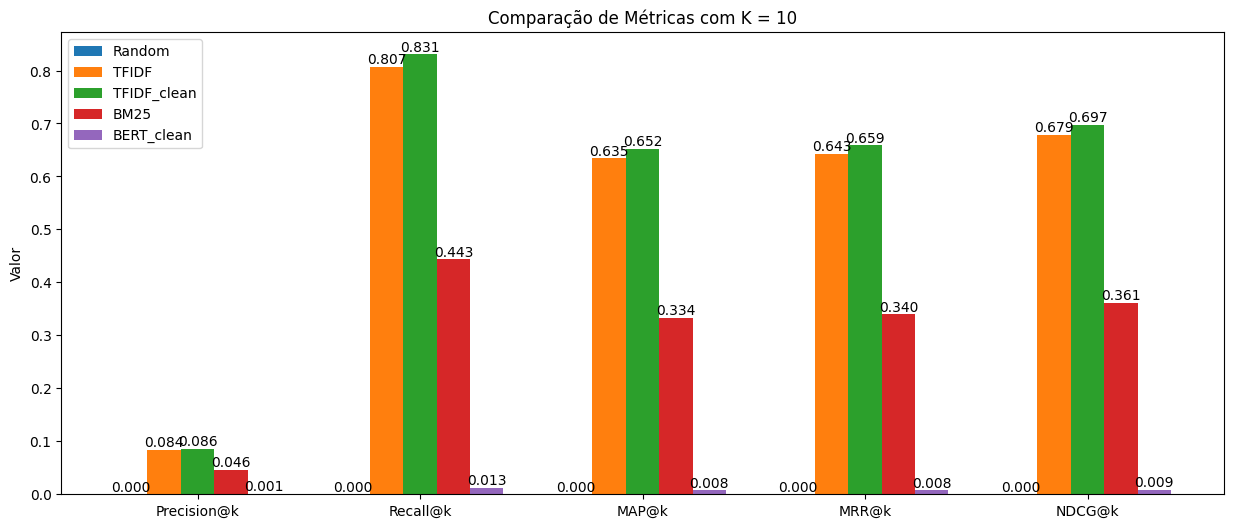

In [24]:
k = 10

# Precision@k
p_random = mean_precision_at_k(top10_results_random, qrels_dict, k=k)
p_tfidf = mean_precision_at_k(top10_results_tfidf, qrels_dict, k=k)
p_tfidf_cl = mean_precision_at_k(top10_results_tfidf_clean, qrels_dict, k=k)
p_bm25 = mean_precision_at_k(topN_results_bm25, qrels_dict, k=k)
# p_bm25_cl = mean_precision_at_k(topN_results_bm25_clean, qrels_dict, k=k)
p_bert_cl = mean_precision_at_k(top10_results_bert, qrels_dict, k=k)

# Recall@k
r_random = mean_recall_at_k(top10_results_random, qrels_dict, k=k)
r_tfidf = mean_recall_at_k(top10_results_tfidf, qrels_dict, k=k)
r_tfidf_cl = mean_recall_at_k(top10_results_tfidf_clean, qrels_dict, k=k)
r_bm25 = mean_recall_at_k(topN_results_bm25, qrels_dict, k=k)
# r_bm25_cl = mean_recall_at_k(topN_results_bm25_clean, qrels_dict, k=k)
r_bert_cl = mean_recall_at_k(top10_results_bert, qrels_dict, k=k)

# MAP@k
map_random = mean_average_precision_at_k(top10_results_random, qrels_dict, k=k)
map_tfidf = mean_average_precision_at_k(top10_results_tfidf, qrels_dict, k=k)
map_tfidf_cl = mean_average_precision_at_k(top10_results_tfidf_clean, qrels_dict, k=k)
map_bm25 = mean_average_precision_at_k(topN_results_bm25, qrels_dict, k=k)
# map_bm25_cl = mean_average_precision_at_k(topN_results_bm25_clean, qrels_dict, k=k)
map_bert_cl = mean_average_precision_at_k(top10_results_bert, qrels_dict, k=k)

# MRR@k
mrr_random = mean_reciprocal_rank(top10_results_random, qrels_dict)
mrr_tfidf = mean_reciprocal_rank(top10_results_tfidf, qrels_dict)
mrr_tfidf_cl = mean_reciprocal_rank(top10_results_tfidf_clean, qrels_dict)
mrr_bm25 = mean_reciprocal_rank(topN_results_bm25, qrels_dict)
# mrr_bm25_cl = mean_reciprocal_rank(topN_results_bm25_clean, qrels_dict)
mrr_bert_cl = mean_reciprocal_rank(top10_results_bert, qrels_dict)

# NDCG@10   
ndcg_random = mean_ndcg_at_k(top10_results_random, qrels_dict, k=k)
ndcg_tfidf = mean_ndcg_at_k(top10_results_tfidf, qrels_dict, k=k)
ndcg_tfidf_cl = mean_ndcg_at_k(top10_results_tfidf_clean, qrels_dict, k=k)
ndcg_bm25 = mean_ndcg_at_k(topN_results_bm25, qrels_dict, k=k)
# ndcg_bm25_cl = mean_ndcg_at_k(topN_results_bm25_clean, qrels_dict, k=k)
ndcg_bert_cl = mean_ndcg_at_k(top10_results_bert, qrels_dict, k=k)

metrics_names = ['Precision@k', 'Recall@k', 'MAP@k', 'MRR@k', 'NDCG@k']
methods = ['Random', 'TFIDF', 'TFIDF_clean', 'BM25', 'BERT_clean']

data = np.array([
    [p_random, p_tfidf, p_tfidf_cl, p_bm25, p_bert_cl],
    [r_random, r_tfidf, r_tfidf_cl, r_bm25, r_bert_cl],
    [map_random, map_tfidf, map_tfidf_cl, map_bm25, map_bert_cl],
    [mrr_random, mrr_tfidf, mrr_tfidf_cl, mrr_bm25, mrr_bert_cl],
    [ndcg_random, ndcg_tfidf, ndcg_tfidf_cl, ndcg_bm25, ndcg_bert_cl]
])

x = np.arange(len(metrics_names))  
width = 0.15  # Reduzido para caber melhor

fig, ax = plt.subplots(figsize=(15, 6))  
for i, method in enumerate(methods):
    bars = ax.bar(x + (i - len(methods)/2 + 0.5) * width, data.T[i], width, label=method)
    # Adiciona rótulos nas barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

ax.set_ylabel('Valor')
ax.set_title('Comparação de Métricas com K = ' + str(k))
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

plt.show()


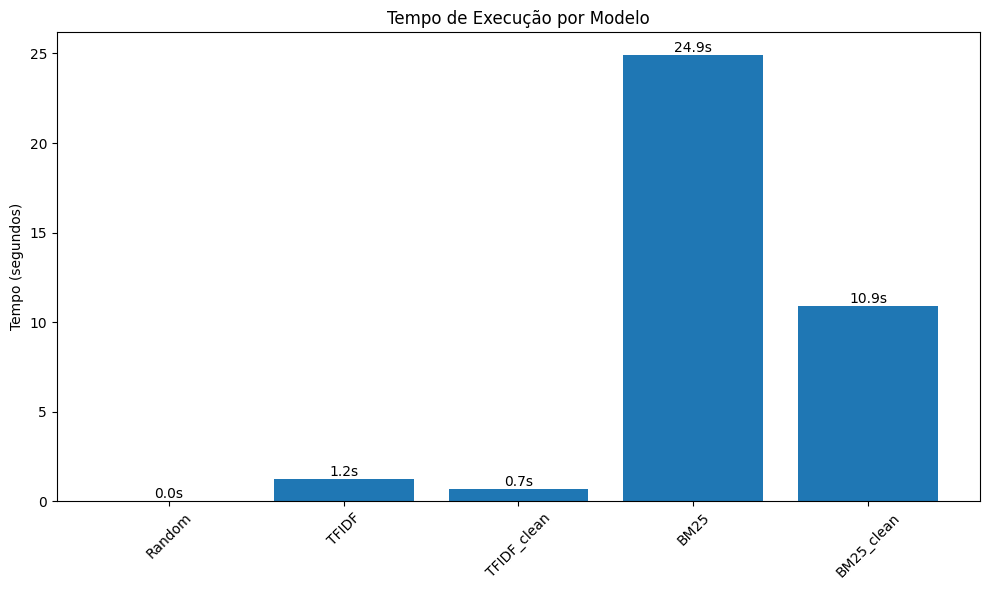

In [19]:
tempos = {
    'Random': execution_time_random,
    'TFIDF': execution_time_tfidf,
    'TFIDF_clean': execution_time_tfidf_clean,
    'BM25': execution_time_bm25,
    'BM25_clean': execution_time_bm25_clean
}

plt.figure(figsize=(10,6))
bars = plt.bar(tempos.keys(), tempos.values())

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s',
            ha='center', va='bottom')

plt.title('Tempo de Execução por Modelo')
plt.ylabel('Tempo (segundos)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [20]:
import matplotlib.pyplot as plt

def plot_metrics_vs_k(models_results, qrels_dict, max_k=K):
    """
    Calcula e plota as métricas Precision@k, Recall@k e MAP@k para cada modelo,
    considerando k de 1 até max_k (padrão 50).

    Parâmetros:
      - models_results: dicionário com os resultados dos modelos. Exemplo:
          {
              'Random': results_random,
              'TFIDF': results_tfidf,
              'TFIDF_clean': results_tfidf_clean,
              ... (outros modelos)
          }
      - qrels_dict: dicionário com os documentos relevantes para cada query.
      - max_k: valor máximo de k a ser considerado.
    """
    k_values = list(range(1, max_k + 1))
    
    # Dicionários para armazenar os valores das métricas para cada modelo
    precision_data = {}
    recall_data = {}
    map_data = {}
    mrr_data = {}
    ndcg_data = {}
    
    # Calcula as métricas para cada valor de k para cada modelo
    for model_name, results in models_results.items():
        precision_data[model_name] = [mean_precision_at_k(results, qrels_dict, k) for k in k_values]
        recall_data[model_name]    = [mean_recall_at_k(results, qrels_dict, k) for k in k_values]
        map_data[model_name]       = [mean_average_precision_at_k(results, qrels_dict, k) for k in k_values]
        mrr_data[model_name]       = [mean_reciprocal_rank(results, qrels_dict) for k in k_values]
        ndcg_data[model_name]      = [mean_ndcg_at_k(results, qrels_dict, k) for k in k_values]
    
    # Cria três subplots (um para cada métrica)
    fig, axs = plt.subplots(1, 5, figsize=(21, 8))
    
    # Plot Precision@k
    for model_name, values in precision_data.items():
        axs[0].plot(k_values, values, marker='o', label=model_name)
    axs[0].set_title("Precision@k")
    axs[0].set_xlabel("k")
    axs[0].set_ylabel("Precision")
    axs[0].legend()
    
    # Plot Recall@k
    for model_name, values in recall_data.items():
        axs[1].plot(k_values, values, marker='o', label=model_name)
    axs[1].set_title("Recall@k")
    axs[1].set_xlabel("k")
    axs[1].set_ylabel("Recall")
    axs[1].legend()
    
    # Plot MAP@k
    for model_name, values in map_data.items():
        axs[2].plot(k_values, values, marker='o', label=model_name)
    axs[2].set_title("MAP@k")
    axs[2].set_xlabel("k")
    axs[2].set_ylabel("MAP")
    axs[2].legend()

    # Plot MRR@k
    for model_name, values in mrr_data.items():
        axs[3].plot(k_values, values, marker='o', label=model_name)
    axs[3].set_title("MRR@k")
    axs[3].set_xlabel("k")
    axs[3].set_ylabel("MRR")
    axs[3].legend()

    # Plot NDCG@k
    for model_name, values in ndcg_data.items():
        axs[4].plot(k_values, values, marker='o', label=model_name)
    axs[4].set_title("NDCG@k")
    axs[4].set_xlabel("k")
    axs[4].set_ylabel("NDCG")
    axs[4].legend()
    
    plt.tight_layout()
    plt.show()

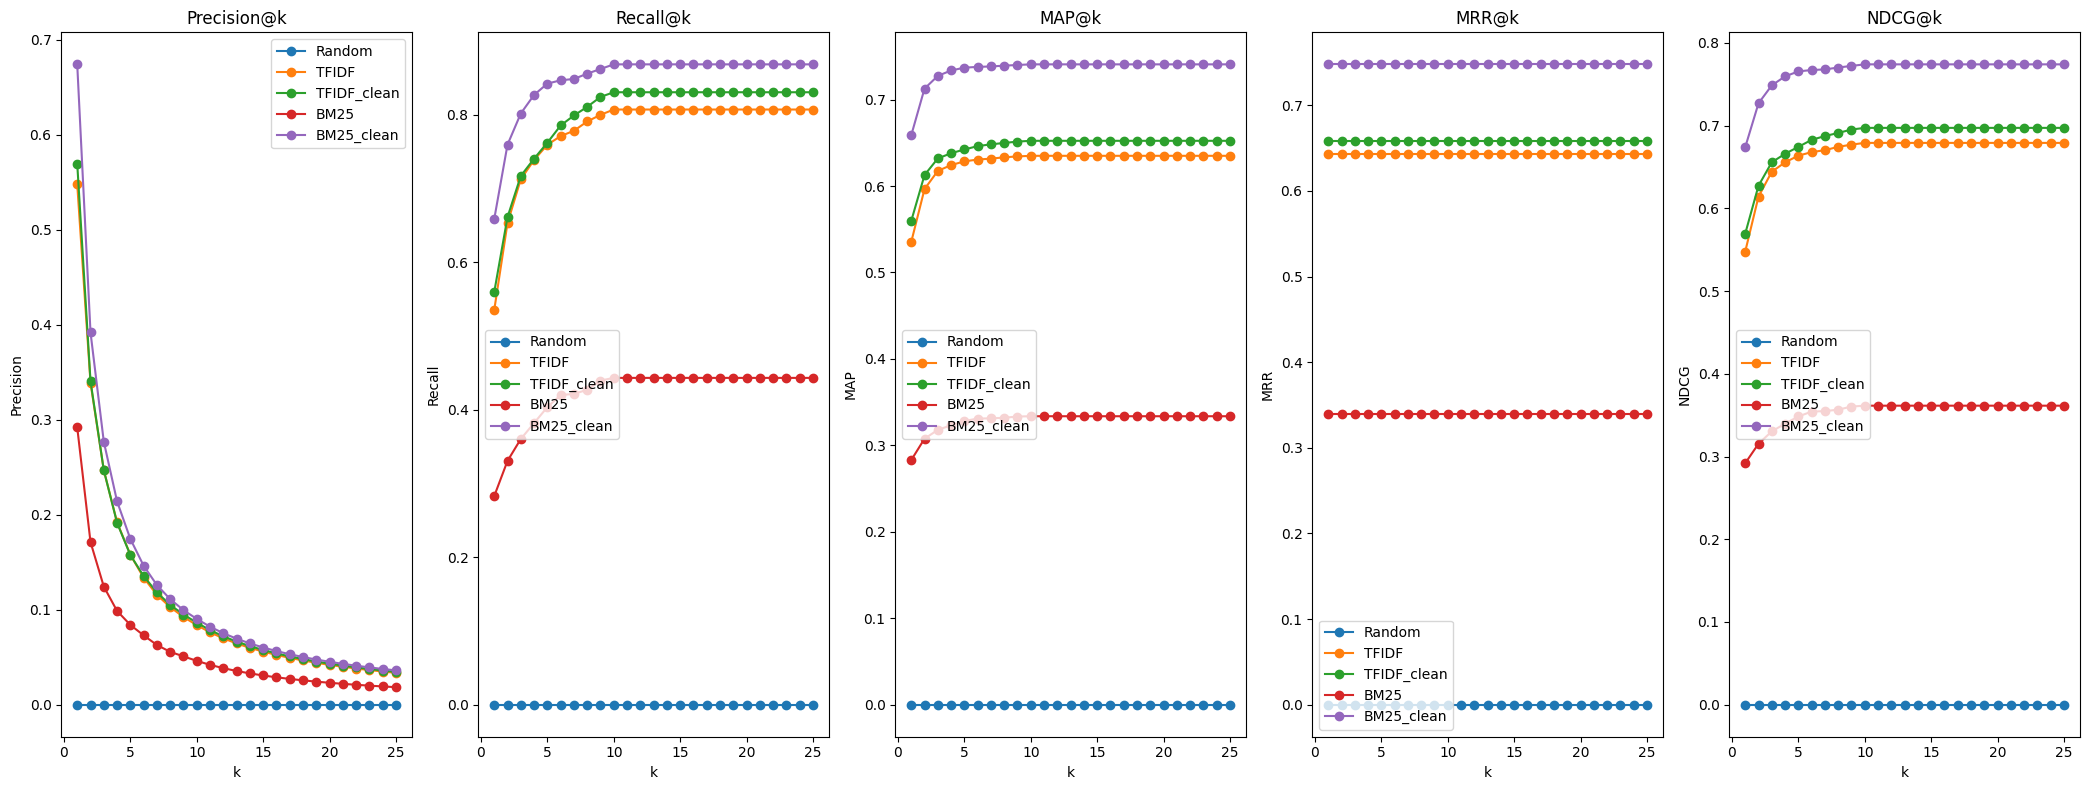

In [21]:
models_results = {
    'Random': top10_results_random,
    'TFIDF': top10_results_tfidf,
    'TFIDF_clean': top10_results_tfidf_clean,
    'BM25': topN_results_bm25,
    'BM25_clean': topN_results_bm25_clean
}

plot_metrics_vs_k(models_results, qrels_dict, max_k=K)

# Teste final

Aqui, vamos puxar todos os datasets de tamanhos variados para ver as métricas de cada modelo.

Para não demorar, vamos fixar a quantidade de queries em 1000 para todos os testes (aumentar não faz diferença, já que no final estamos pegando a média de todas as queries) e variar apenas a quantidade de documentos. 

In [22]:
# lista_pkl = [
#     "../data_clean/subset_msmarco_train_0.01_9.pkl",
#     "../data_clean/subset_msmarco_train_0.01_99.pkl",
#     "../data_clean/subset_msmarco_train_0.01_999.pkl",
#     "../data_clean/subset_msmarco_train_0.05_9.pkl",
#     "../data_clean/subset_msmarco_train_0.05_99.pkl",
#     "../data_clean/subset_msmarco_train_0.05_999.pkl",
#     "../data_clean/subset_msmarco_train_0.1_9.pkl",
#     "../data_clean/subset_msmarco_train_0.1_99.pkl",
#     "../data_clean/subset_msmarco_train_0.1_999.pkl"
# ]

# K = 10 

# results_metrics_precision = {}
# results_metrics_recall = {}
# results_metrics_map = {}

# execution_time_random_dict = {}
# execution_time_tfidf_clean_dict = {}
# execution_time_bm25_clean_dict = {}

# for pkl in lista_pkl:
#     print(f'Processando arquivo: {pkl}')
#     with open(pkl, 'rb') as f:
#         data = pickle.load(f)
        
#     irrelevant_docs = str(pkl.split('_')[-1].split('.')[0])
#     sample = str(pkl.split('_')[-2])

#     # Seleciona TODOS os documentos
#     docs_dict_clean = data['docs_dict']
    
#     # Seleciona 1000 queries aleatórias
#     query_ids = list(data['queries_dict'].keys())
#     selected_query_ids = random.sample(query_ids, min(1000, len(query_ids)))
#     queries_dict_clean = {qid: data['queries_dict'][qid] for qid in selected_query_ids}
    
#     # Seleciona 1000 qrels aleatórios
#     qrels_ids = list(data['qrels_dict'].keys())
#     qrels_dict = {qid: data['qrels_dict'][qid] for qid in selected_query_ids}

#     # roda todos os modelos
#     top10_results_random, execution_time_random = random_search(docs_dict_clean, queries_dict_clean, K=K)
#     top10_results_tfidf_clean, execution_time_tfidf_clean = tfidf_search(docs_dict_clean, queries_dict_clean, K=K)
#     topN_results_bm25_clean, execution_time_bm25_clean = bm25_search(docs_dict_clean, queries_dict_clean, K=K)  

#     # calcula as métricas
#     precision_data = {}
#     recall_data = {}
#     map_data = {}

#     p_random = mean_precision_at_k(top10_results_random, qrels_dict, k=K)
#     r_random = mean_recall_at_k(top10_results_random, qrels_dict, k=K)
#     map_random = mean_average_precision_at_k(top10_results_random, qrels_dict, k=K)

#     p_tfidf_clean = mean_precision_at_k(top10_results_tfidf_clean, qrels_dict, k=K)
#     r_tfidf_clean = mean_recall_at_k(top10_results_tfidf_clean, qrels_dict, k=K)
#     map_tfidf_clean = mean_average_precision_at_k(top10_results_tfidf_clean, qrels_dict, k=K)

#     p_bm25_clean = mean_precision_at_k(topN_results_bm25_clean, qrels_dict, k=K)
#     r_bm25_clean = mean_recall_at_k(topN_results_bm25_clean, qrels_dict, k=K)
#     map_bm25_clean = mean_average_precision_at_k(topN_results_bm25_clean, qrels_dict, k=K)
    
#     precision_data['Random'] = p_random
#     recall_data['Random'] = r_random
#     map_data['Random'] = map_random

#     precision_data['TFIDF_clean'] = p_tfidf_clean
#     recall_data['TFIDF_clean'] = r_tfidf_clean
#     map_data['TFIDF_clean'] = map_tfidf_clean

#     precision_data['BM25_clean'] = p_bm25_clean
#     recall_data['BM25_clean'] = r_bm25_clean
#     map_data['BM25_clean'] = map_bm25_clean
    
#     results_metrics_precision[sample+'_'+irrelevant_docs] = {
#         'Random': p_random,
#         'TFIDF_clean': p_tfidf_clean,
#         'BM25_clean': p_bm25_clean
#     }
    
#     results_metrics_recall[sample+'_'+irrelevant_docs] = {
#         'Random': r_random,
#         'TFIDF_clean': r_tfidf_clean,
#         'BM25_clean': r_bm25_clean
#     }
    
#     results_metrics_map[sample+'_'+irrelevant_docs] = {
#         'Random': map_random,
#         'TFIDF_clean': map_tfidf_clean,
#         'BM25_clean': map_bm25_clean
#     }

#     execution_time_random_dict[sample+'_'+irrelevant_docs] = execution_time_random
#     execution_time_tfidf_clean_dict[sample+'_'+irrelevant_docs] = execution_time_tfidf_clean
#     execution_time_bm25_clean_dict[sample+'_'+irrelevant_docs] = execution_time_bm25_clean

In [23]:
# def plot_metric_heatmap(metric_results, metric_name):
#     samples = set()
#     docs = set()
#     for key in metric_results.keys():
#         sample_str, doc_str = key.split('_')
#         samples.add(float(sample_str))
#         docs.add(int(doc_str))
#     samples = sorted(list(samples))
#     docs = sorted(list(docs))
    
#     modelos = list(next(iter(metric_results.values())).keys())
    
#     # Para cada modelo, cria a matriz de resultados e plota o heatmap
#     for modelo in modelos:
#         heatmap = np.full((len(docs), len(samples)), np.nan)
#         for key, valores_modelos in metric_results.items():
#             sample_str, doc_str = key.split('_')
#             sample_val = float(sample_str)
#             doc_val = int(doc_str)
#             col_idx = samples.index(sample_val)
#             row_idx = docs.index(doc_val)
#             heatmap[row_idx, col_idx] = valores_modelos[modelo]
        
#         plt.figure(figsize=(6, 5))
#         plt.imshow(heatmap, cmap='viridis', interpolation='nearest')
#         plt.title(f"{modelo} - {metric_name}")
#         plt.xlabel("Sample")
#         plt.ylabel("Documentos Irrelevantes")
#         plt.xticks(ticks=np.arange(len(samples)), labels=[str(s) for s in samples])
#         plt.yticks(ticks=np.arange(len(docs)), labels=[str(d) for d in docs])
#         cbar = plt.colorbar()
#         cbar.set_label(metric_name)
#         plt.show()

# plot_metric_heatmap(results_metrics_precision, "Precision")
# plot_metric_heatmap(results_metrics_recall, "Recall")
# plot_metric_heatmap(results_metrics_map, "MAP")
